# Evaluating difference in global Efficiency in timepoints and groups for spontaneous evolution

In [2]:
import pandas as pd
from scipy import stats
from statsmodels.stats import multitest
from multipy.fdr import qvalue
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings; warnings.simplefilter('ignore')

In [4]:
global_eff_auc_df = pd.read_csv('./glob_eff_auc_df.csv')
st_global_eff_auc_df = global_eff_auc_df[global_eff_auc_df['group'] == 'st']
hc_global_eff_auc_df = global_eff_auc_df[global_eff_auc_df['group'] == 'hc']

In [5]:
global_eff_df = pd.read_csv('./glob_eff_df.csv')
st_global_eff_df = global_eff_df[global_eff_df['group'] == 'st']
hc_global_eff_df = global_eff_df[global_eff_df['group'] == 'hc']


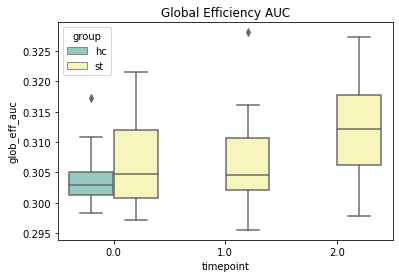

In [6]:
ax = sns.boxplot(x="timepoint", y="glob_eff_auc", hue="group", data=global_eff_auc_df, palette="Set3")
ax.set_title('Global Efficiency AUC')
plt.show()

In [ ]:
ax = sns.boxplot(x="timepoint", y="glob_eff", hue="group", data=global_eff_df, palette="Set3")
ax.set_title('Global Efficiency')
plt.show()


## 1. Comparing Eglob AUC

### A. Compare different time-points for patients
Here we use dependent t-tests, then corrected by Benjamini-Hochberg, as well as Storey procedures.

In [ ]:
_, tp1_vs_tp2_p_val = stats.ttest_rel(
    st_global_eff_auc_df[st_global_eff_auc_df['timepoint'] == 0]['glob_eff_auc'],
    st_global_eff_auc_df[st_global_eff_auc_df['timepoint'] == 1]['glob_eff_auc'],
    nan_policy='omit')

_, tp1_vs_tp3_p_val = stats.ttest_rel(
    st_global_eff_auc_df[st_global_eff_auc_df['timepoint'] == 0]['glob_eff_auc'],
    st_global_eff_auc_df[st_global_eff_auc_df['timepoint'] == 2]['glob_eff_auc'],
nan_policy='omit')

_, tp2_vs_tp3_p_val = stats.ttest_rel(
    st_global_eff_auc_df[st_global_eff_auc_df['timepoint'] == 1]['glob_eff_auc'],
    st_global_eff_auc_df[st_global_eff_auc_df['timepoint'] == 2]['glob_eff_auc'],
nan_policy='omit')

print('Uncorrected pvals:', tp1_vs_tp2_p_val, tp1_vs_tp3_p_val, tp2_vs_tp3_p_val)

In [ ]:
_, timepoint_bh_fdr_pvals, _, _ = multitest.multipletests([tp1_vs_tp2_p_val, tp1_vs_tp3_p_val, tp2_vs_tp3_p_val], method='fdr_bh')
print('BH FDR corrected p-vals are:', timepoint_bh_fdr_pvals)

In [ ]:
_, timepoint_storey_fdr_pvals = qvalue([tp1_vs_tp2_p_val, tp1_vs_tp3_p_val, tp2_vs_tp3_p_val])
print('Storey FDR corrected p-vals are:', timepoint_storey_fdr_pvals)

### B. Compare patients to healthy controls
Here we use independent t-tests, then corrected by Benjamini-Hochberg, as well as Storey procedures.

In [ ]:
_, st_tp1_vs_hc_p_val = stats.ttest_ind(
    st_global_eff_auc_df[st_global_eff_auc_df['timepoint'] == 0]['glob_eff_auc'],
    hc_global_eff_auc_df['glob_eff_auc'],
    nan_policy='omit')


_, st_tp2_vs_hc_p_val = stats.ttest_ind(
    st_global_eff_auc_df[st_global_eff_auc_df['timepoint'] == 1]['glob_eff_auc'],
    hc_global_eff_auc_df['glob_eff_auc'],
    nan_policy='omit'
    )


_, st_tp3_vs_hc_p_val = stats.ttest_ind(
    st_global_eff_auc_df[st_global_eff_auc_df['timepoint'] == 2]['glob_eff_auc'],
    hc_global_eff_auc_df['glob_eff_auc'],
    nan_policy='omit'
    )

print('Uncorrected pvals:', st_tp1_vs_hc_p_val, st_tp2_vs_hc_p_val, st_tp3_vs_hc_p_val)

In [ ]:
_, group_bh_fdr_pvals, _, _ = multitest.multipletests([st_tp1_vs_hc_p_val, st_tp2_vs_hc_p_val, st_tp3_vs_hc_p_val], method='fdr_bh')
print('BH FDR corrected p-vals are:', group_bh_fdr_pvals)

In [ ]:
_, group_storey_fdr_pvals = qvalue([st_tp1_vs_hc_p_val, st_tp2_vs_hc_p_val, st_tp3_vs_hc_p_val])
print('Storey FDR corrected p-vals are:', group_storey_fdr_pvals)


### C. Correlation with mean degree AUC
Comparing across all subjects (HC + ST) and then only patients

In [ ]:
mean_degree_auc_df = pd.read_csv('./mean_degree_auc_df.csv')
mean_degree_and_gEff_auc_df = pd.merge(global_eff_auc_df, mean_degree_auc_df, on=["subject", "timepoint", "group"])
print('Overall Spearmann correlation coefficient:')
mean_degree_and_gEff_auc_df[['mean_degree_auc', 'glob_eff_auc']].corr(method='spearman')

In [ ]:
print('Only patients Spearmann correlation coefficient:')
mean_degree_and_gEff_auc_df[mean_degree_and_gEff_auc_df['group'] == 'st'][['mean_degree_auc', 'glob_eff_auc']].corr(method='spearman')

## 2. Comparing Eglob across bins
Using repeated measures ANOVA here instead of t-test (as bins are defacto repeated measures for a single subject), then corrected by Benjamini-Hochberg, as well as Storey procedures.

Rationale: more measures might lead to higher statistical power.

### A. Compare different time-points for patients

In [ ]:
tp1_vs_tp2_df = st_global_eff_df[st_global_eff_df['timepoint'].isin([0, 1])]
timepoint_aov_tp1_vs_tp2_df = pg.rm_anova(data=tp1_vs_tp2_df, dv='glob_eff', subject='subject', within='timepoint', detailed=True)
timepoint_aov_tp1_vs_tp2_pval = timepoint_aov_tp1_vs_tp2_df['p-unc'][0]

tp1_vs_tp3_df = st_global_eff_df[st_global_eff_df['timepoint'].isin([0, 2])]
timepoint_aov_tp1_vs_tp3_df = pg.rm_anova(data=tp1_vs_tp3_df, dv='glob_eff', subject='subject', within='timepoint', detailed=True)
timepoint_aov_tp1_vs_tp3_pval = timepoint_aov_tp1_vs_tp3_df['p-unc'][0]

tp2_vs_tp3_df = st_global_eff_df[st_global_eff_df['timepoint'].isin([1, 2])]
timepoint_aov_tp2_vs_tp3_df = pg.rm_anova(data=tp2_vs_tp3_df, dv='glob_eff', subject='subject', within='timepoint', detailed=True)
timepoint_aov_tp2_vs_tp3_pval = timepoint_aov_tp2_vs_tp3_df['p-unc'][0]

print('Uncorrected pvals', timepoint_aov_tp1_vs_tp2_pval, timepoint_aov_tp1_vs_tp3_pval, timepoint_aov_tp2_vs_tp3_pval)

In [ ]:
_, timepoint_aov_bh_fdr_pvals, _, _ = multitest.multipletests([timepoint_aov_tp1_vs_tp2_pval, timepoint_aov_tp1_vs_tp3_pval, timepoint_aov_tp2_vs_tp3_pval], method='fdr_bh')
print('BH FDR corrected p-vals are:', timepoint_aov_bh_fdr_pvals)

In [ ]:
_, timepoint_aov_storey_fdr_pvals = qvalue([timepoint_aov_tp1_vs_tp2_pval, timepoint_aov_tp1_vs_tp3_pval, timepoint_aov_tp2_vs_tp3_pval])
print('Storey FDR corrected p-vals are:', timepoint_aov_storey_fdr_pvals)

### B. Compare patients to healthy controls

In [ ]:
tp1_vs_hc_df = global_eff_df[(global_eff_df['timepoint'] == 0) | (global_eff_df['group'] == 'hc')]
group_aov_tp1_vs_hc_df = pg.rm_anova(data=tp1_vs_hc_df, dv='glob_eff', subject='subject', within='group', detailed=True)
group_aov_tp1_vs_hc_pval = group_aov_tp1_vs_hc_df['p-unc'][0]

tp2_vs_hc_df = global_eff_df[(global_eff_df['timepoint'] == 1) | (global_eff_df['group'] == 'hc')]
group_aov_tp2_vs_hc_df = pg.rm_anova(data=tp2_vs_hc_df, dv='glob_eff', subject='subject', within='group', detailed=True)
group_aov_tp2_vs_hc_pval = group_aov_tp2_vs_hc_df['p-unc'][0]

tp3_vs_hc_df = global_eff_df[(global_eff_df['timepoint'] == 2) | (global_eff_df['group'] == 'hc')]
group_aov_tp3_vs_hc_df = pg.rm_anova(data=tp3_vs_hc_df, dv='glob_eff', subject='subject', within='group', detailed=True)
group_aov_tp3_vs_hc_pval = group_aov_tp3_vs_hc_df['p-unc'][0]

print('Uncorrected pvals', group_aov_tp1_vs_hc_pval, group_aov_tp2_vs_hc_pval, group_aov_tp3_vs_hc_pval)



Analysis: intra-subject variance is too big rendering ANOVA across all density bins useless 